In [4]:
import matplotlib.pyplot as plt
import numpy as np
from plots import *
import scipy.io
from scipy.signal import butter, lfilter, sosfilt, freqz

data = 'Old Data'
# data = 'New Data'

if data == 'New Data':
    filepath = "C:\\Users\\Owner\\OneDrive\\Documents\\GitHub\\SOAEpeaks\\Data\\"
    wf_title = 'ACfls27rearSOAEwfD01.txt'
    wf = np.loadtxt(filepath + wf_title)
    sr = 44100
else:
    filepath = "C:\\Users\\Owner\\OneDrive\\Documents\\GitHub\\SOAEpeaks\\Data\\"
    wf_title = 'anole_AC6rearSOAEwfB1.mat'
    mat = scipy.io.loadmat(filepath + wf_title)
    wf = np.squeeze(mat['wf'])
    sr=44100


In [ ]:
# Just the butterworth highpass filter
cutoff_freq = 1000
order = 2
b, a = butter(order, cutoff_freq,'hp',fs=sr,output='ba')
wf_filt = lfilter(b, a, wf)

# Generate the impulse response of the filter
impulse = np.zeros(1000)
impulse[0] = 1  # Dirac delta impulse
impulse_response = lfilter(b, a, impulse)

# Compute the Fourier Transform of the impulse response
frequency_response = np.fft.fft(impulse_response)
frequencies = np.fft.fftfreq(len(impulse_response), d=1/sr)

# Calculate magnitude (in dB) and phase (in degrees)
magnitude = 20 * np.log10(np.abs(frequency_response))
phase = np.unwrap(np.angle(frequency_response, deg=False))


# Calculate coherence
tau = 23.22 / 1000
xi = 5.80 / 1000

d_lizard_filt = get_coherence(wf_filt, sr, t_win=tau, t_shift=xi, ref_type="next_win", hann=False, return_all=True)
coherence_filt = d_lizard_filt["coherence"]
phase_diffs_filt = d_lizard_filt["phase_diffs"]
f_filt = d_lizard_filt["freq_ax"]

d_lizard = get_coherence(wf, sr, t_win=tau, t_shift=xi, ref_type="next_win", hann=False, return_all=True)
coherence = d_lizard["coherence"]
phase_diffs = d_lizard["phase_diffs"]
f = d_lizard["freq_ax"]

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)

# Create the first y-axis (magnitude)
ax1 = plt.gca()
ax1.plot(frequencies[:len(frequencies)//2]/1000, phase[:len(frequencies)//2], color='red', label='Phase [degrees]')
ax1.set_ylabel('Phase [radians]', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.grid(True)
ax1.set_xlim(0, 7)
ax1.set_title('Magnitude and Phase Response of Butterworth Highpass Filter')

# Create the second y-axis (phase)
ax2 = ax1.twinx()
ax2.plot(frequencies[:len(frequencies)//2]/1000, magnitude[:len(frequencies)//2], color='blue', label='Magnitude [dB]')
ax2.set_xlabel('Frequency [kHz]')
ax2.set_ylabel('Magnitude [dB]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')


# Add legends
ax1.legend(loc='center left')
ax2.legend(loc='center right')

plt.subplot(2, 1, 2)
plt.title(r"$C_{\xi}$ with "+ r"$\tau$ = " + f"{tau*1000:.2f}ms, " + r"$\xi$ = " + f"{xi*1000:.2f}ms" + f" ({wf_title})", fontsize=20)
plt.ylabel("Vector Strength", fontsize=18)
plt.xlabel("Frequency (kHz)", fontsize=18)
plt.plot(f/1000, coherence, label = 'Unfiltered')
plt.plot(f/1000, coherence_filt, label = 'Filtered')
plt.legend()
plt.xlim(0, 7)

plt.tight_layout()
plt.show()

In [51]:
# My theory would be that the low frequency stuff is maybe messing with the estimation of the phase at the beginning of each window. 
# Maybe, depending on the length of the window, it can either hurt or help the coherence, leading to the sawtooth pattern

In [14]:
from scipy.signal import welch
def plot_filter_comparison(tau, xi, cutoff_freq, filter_plots=True):
    # First plot the butterworth 

    # Butterworth highpass filter
    order = 100
    sos = butter(order, cutoff_freq,'hp',fs=sr,output='sos')
    wf_filt = sosfilt(sos, wf)
    
    def brute_filter(wf, sr, cutoff_freq):
        fft_coefficients = np.fft.rfft(wf)
        frequencies = np.fft.rfftfreq(len(wf), d=1/sr)

        # Zero out coefficients from 0 Hz to cutoff_frequency Hz
        fft_coefficients[frequencies <= cutoff_freq] = 0

        # Compute the inverse real-valued FFT (irfft)
        return np.fft.irfft(fft_coefficients)
    
    wf_brute_filt = brute_filter(wf, sr, cutoff_freq)
    
    if filter_plots:
        # Butterworth Filter
        
        # Generate the impulse response of the filter
        impulse = np.zeros(1000)
        impulse[0] = 1  # Dirac delta impulse
        impulse_response = sosfilt(sos, impulse)

        # Compute the Fourier Transform of the impulse response
        frequency_response = np.fft.fft(impulse_response)
        frequencies = np.fft.fftfreq(len(impulse_response), d=1/sr)

        # Calculate magnitude (in dB) and phase (in degrees)
        magnitude = 20 * np.log10(np.maximum(1e-20, np.abs(frequency_response)))
        phase = np.unwrap(np.angle(frequency_response, deg=False))


        plt.figure(figsize=(18, 6))
        plt.subplot(3, 1, 1)


        # Create the first y-axis (phase)
        ax1 = plt.gca()
        ax1.plot(frequencies[:len(frequencies)//2]/1000, phase[:len(frequencies)//2], color='red', label='Phase [degrees]')
        ax1.set_ylabel('Phase [radians]', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.grid(True)
        ax1.set_xlim(0, 7)
        ax1.set_title(f'Magnitude and Phase Response of Butterworth Highpass Filter (order = {order}, cutoff = {cutoff_freq} Hz)')

        # Create the second y-axis (mag)
        ax2 = ax1.twinx()
        ax2.plot(frequencies[:len(frequencies)//2]/1000, magnitude[:len(frequencies)//2], color='blue', label='Magnitude [dB]')
        ax2.set_xlabel('Frequency [kHz]')
        ax2.set_ylabel('Magnitude [dB]', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')

        # Add legends
        ax1.legend(loc='lower right')
        ax2.legend(loc='center right')
        
        
        # BRUTE FILTER
        plt.subplot(3, 1, 2)
        
        
        # Generate the impulse response of the filter
        impulse = np.zeros(1000)
        impulse[0] = 1  # Dirac delta impulse
        impulse_response = brute_filter(impulse, sr, cutoff_freq)

        # Compute the Fourier Transform of the impulse response
        frequency_response = np.fft.fft(impulse_response)
        frequencies = np.fft.fftfreq(len(impulse_response), d=1/sr)

        # Calculate magnitude (in dB) and phase (in degrees)
        magnitude = 20 * np.log10(np.maximum(1e-20, np.abs(frequency_response)))
        phase = np.unwrap(np.angle(frequency_response, deg=False))

        # Create the first y-axis (phase)
        ax1 = plt.gca()
        ax1.plot(frequencies[:len(frequencies)//2]/1000, phase[:len(frequencies)//2], color='red', label='Phase [degrees]')
        ax1.set_ylabel('Phase [radians]', color='red')
        ax1.tick_params(axis='y', labelcolor='red')
        ax1.grid(True)
        ax1.set_xlim(0, 7)
        ax1.set_title(f'Magnitude and Phase Response of "Brute" Highpass Filter (cutoff = {cutoff_freq} Hz)')

        # Create the second y-axis (mag)
        ax2 = ax1.twinx()
        ax2.plot(frequencies[:len(frequencies)//2]/1000, magnitude[:len(frequencies)//2], color='blue', label='Magnitude [dB]')
        ax2.set_xlabel('Frequency [kHz]')
        ax2.set_ylabel('Magnitude [dB]', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        
        # Add legends
        ax1.legend(loc='lower right')
        ax2.legend(loc='center right')
        plt.subplot(3, 1, 3)


    # Calculate coherence
    tau = tau / 1000
    xi = xi / 1000

    d_lizard_brute_filt = get_coherence(wf_brute_filt, sr, t_win=tau, t_shift=xi, ref_type="next_win", hann=False, return_all=True)
    coherence_brute_filt = d_lizard_brute_filt["coherence"]
    phase_diffs_brute_filt = d_lizard_brute_filt["phase_diffs"]
    f_brute_filt = d_lizard_brute_filt["freq_ax"]

    d_lizard_filt = get_coherence(wf_filt, sr, t_win=tau, t_shift=xi, ref_type="next_win", hann=False, return_all=True)
    coherence_filt = d_lizard_filt["coherence"]
    phase_diffs_filt = d_lizard_filt["phase_diffs"]
    f_filt = d_lizard_filt["freq_ax"]

    d_lizard = get_coherence(wf, sr, t_win=tau, t_shift=xi, ref_type="next_win", hann=False, return_all=True)
    coherence = d_lizard["coherence"]
    phase_diffs = d_lizard["phase_diffs"]
    f = d_lizard["freq_ax"]

    f_psd, psd_lizard = welch(wf, sr, nperseg=int(tau*sr))
    
    ax1=plt.gca()
    ax1.set_title(r"$C_{\xi}$ with "+ r"$\tau$ = " + f"{tau*1000:.2f}ms, " + r"$\xi$ = " + f"{xi*1000:.2f}ms, Cutoff = {cutoff_freq}Hz" + f" ({wf_title})", fontsize=20)
    ax1.set_ylabel("Vector Strength", fontsize=18)
    ax1.set_xlabel("Frequency (kHz)", fontsize=18)
    ax1.plot(f/1000, coherence, label = 'Unfiltered')
    ax1.plot(f/1000, coherence_brute_filt, label = '"Brute" Filtered')
    ax1.plot(f/1000, coherence_filt, label = 'Butterworth Filtered')
    ax1.set_ylim(0, 1)
    ax1.legend()
    ax2 = ax1.twinx()
    ax2.plot(f_psd/1000, 10*np.log10(psd_lizard), label ='PSD', color='red')
    ax2.set_ylabel("PSD (dB)")
    ax2.legend(loc='upper right')
    ax2.set_xlim(0, 7)
    ax2.set_ylim(-110, -85)

c:\ProgramData\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\ProgramData\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\ProgramData\miniconda3\lib\site-packages\scipy\signal\_filter_design.py:2690: RuntimeWarning: invalid value encountered in scalar divide
  k_z = k * real(prod(fs2 - z) / prod(fs2 - p))


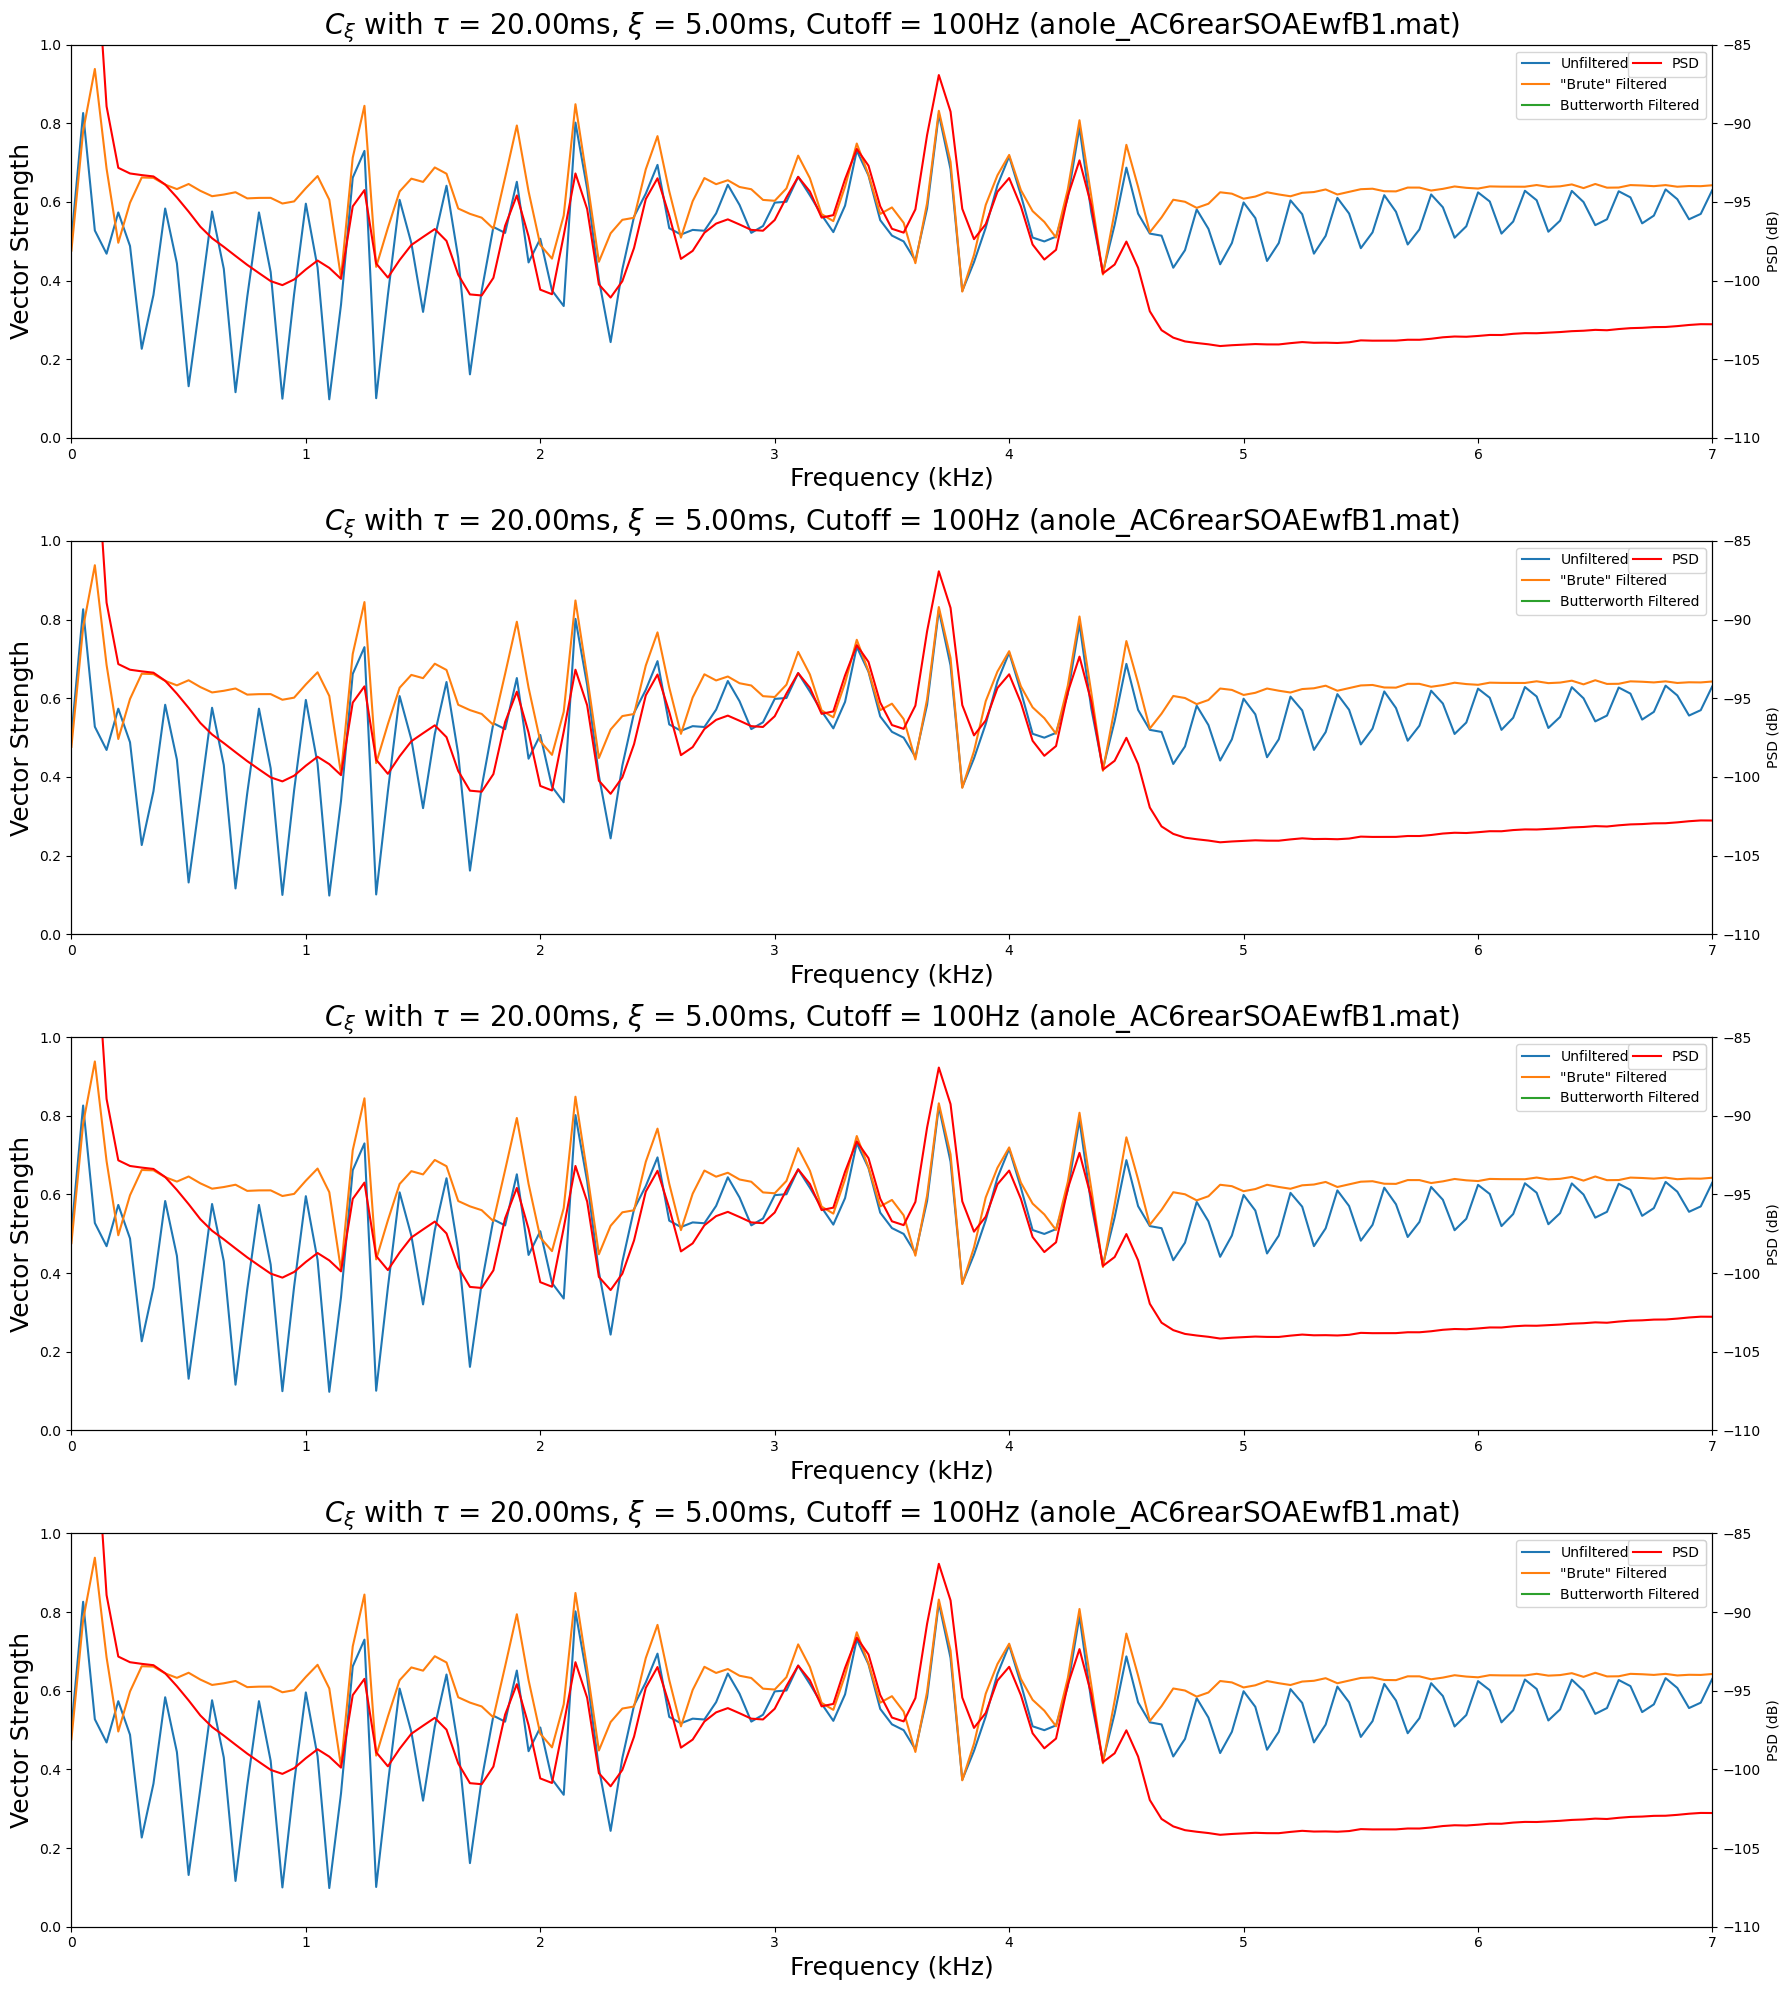

In [ ]:
tau=20
xi=5
cutoffs = [10, 100, 500, 1000]
n = len(cutoffs)
plt.figure(figsize=(18, 5*n))
i = 0
for cutoff_freq in [10, 100, 500, 1000]:
    i+=1
    plt.subplot(n, 1, i)
    plot_filter_comparison(tau, xi, cutoff_freq, filter_plots=False)
plt.tight_layout()
plt.show()

<Figure size 1800x1200 with 0 Axes>

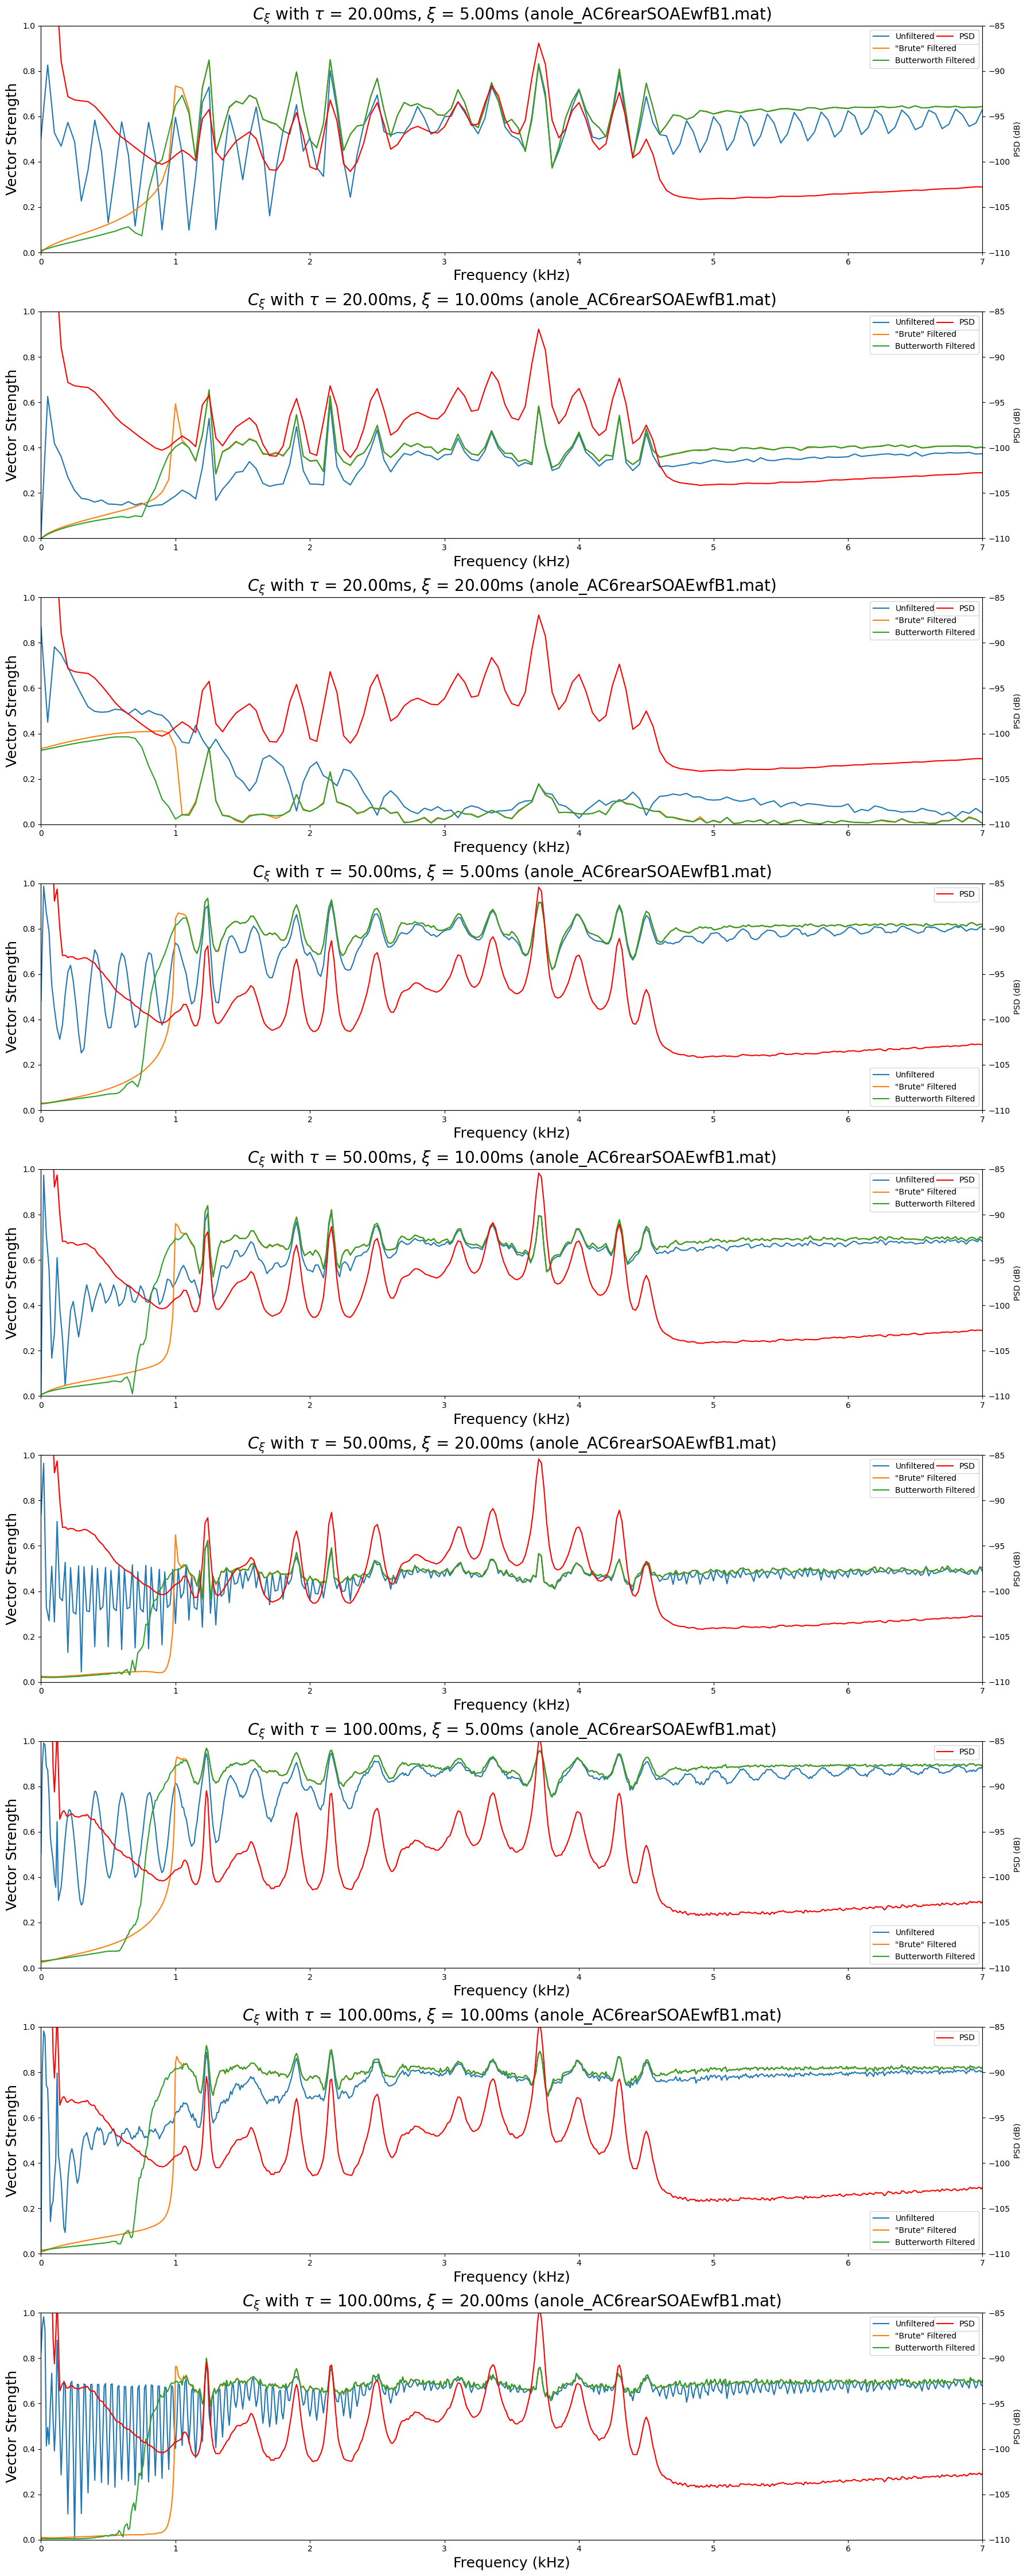

In [ ]:
plt.figure(figsize=(18, 12))
taus = [20, 50, 100]
xis = [5, 10, 20]
n = len(xis) * len(taus)
plt.figure(figsize=(18, 5*n))
i = 0
for tau in taus: 
    for xi in xis:
        i+=1
        plt.subplot(n, 1, i)
        plot_filter_comparison(tau, xi, filter_plots=False)
plt.tight_layout()
plt.show()